In [1]:
import os
import sys
import librosa
import tflearn
import pydub
import wave
import pickle
import speech_data
import segment_data
import tensorflow as tf
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
%matplotlib inline

#cur = os.getcwd()
#os.chdir('/home/cc/')
#import pyAudioAnalysis
#os.chdir(cur)

hdf5 not supported (please install/reinstall h5py)


/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# load constants - training directory, testing directory
training_data = '/home/cc/Data/Dev-Clean-Full/'
#testing_data = '/home/cc/Audio/testing/'
training_seg = '/home/cc/Data/Segment-Two/'
#testing_seg = '/home/cc/Audio/testing-seg/'

In [3]:
# load one wav file to analyze, play it back
wav_file = os.listdir(training_data)[0]
y, sr = librosa.load(training_data + wav_file)
IPython.display.Audio(data=y, rate=sr)

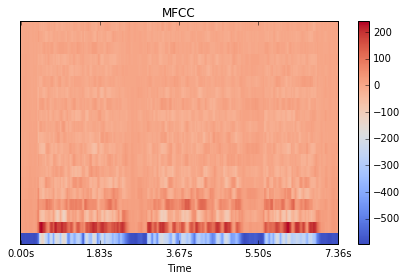

In [4]:
# perform mfcc calculation, display the result in graphic form
mfcc = librosa.feature.mfcc(y=y, sr=sr)
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

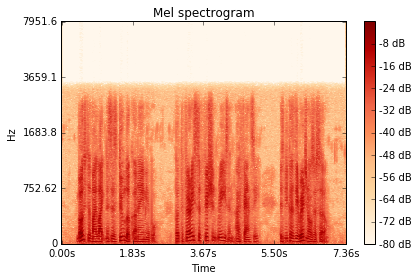

In [5]:
# additionally, display the mel-spectrogram of the audio file
m_spect = librosa.feature.melspectrogram(y=y, sr=sr)
D = librosa.stft(y)
S, phase = librosa.magphase(D)
components, activations = librosa.decompose.decompose(S, n_components=8, sort=True)
librosa.display.specshow(librosa.logamplitude(S, ref_power=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [8]:
# before training, segment the data into two-second chunks if it is not already
if len(os.listdir(training_seg)) is 0:
    segment_data.segment(training_data, training_seg, 2)
elif len(os.listdir(testing_seg)) is 0:
    segment_data.segment(testing_data, testing_seg, 2)

In [6]:
# run this if the mfcc matrices are already calculated in pickle form:
X = pickle.load(open('/home/cc/Data/pickle_files/speaker40_2secX.p', 'rb'))
Y = pickle.load(open('/home/cc/Data/pickle_files/speaker40_2secY.p', 'rb'))
speakers = speech_data.get_speakers(training_seg)

number of files: 6929
(40, ' speakers: ', ['Speaker28', 'Speaker29', 'Speaker20', 'Speaker21', 'Speaker22', 'Speaker23', 'Speaker24', 'Speaker31', 'Speaker26', 'Speaker4', 'Speaker6', 'Speaker25', 'Speaker27', 'Speaker1', 'Speaker0', 'Speaker3', 'Speaker2', 'Speaker5', 'Speaker11', 'Speaker7', 'Speaker10', 'Speaker9', 'Speaker8', 'Speaker13', 'Speaker34', 'Speaker15', 'Speaker14', 'Speaker37', 'Speaker36', 'Speaker35', 'Speaker12', 'Speaker33', 'Speaker32', 'Speaker17', 'Speaker30', 'Speaker19', 'Speaker18', 'Speaker16', 'Speaker39', 'Speaker38'])


In [6]:
# calculate the mfcc matrices for training from the segmented data
X = []
Y = []
speakers = speech_data.get_speakers(training_seg)
for f in os.listdir(training_seg):
    Y.append(speech_data.one_hot_from_item(speech_data.speaker(f), speakers))
    y, sr = librosa.load(training_seg + f)
    X.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
pickle.dump(X, open('/home/cc/Data/pickle_files/speaker40_2secX.p', 'wb'))
pickle.dump(Y, open('/home/cc/Data/pickle_files/speaker40_2secY.p', 'wb'))

number of files: 6929
(40, ' speakers: ', ['Speaker28', 'Speaker29', 'Speaker20', 'Speaker21', 'Speaker22', 'Speaker23', 'Speaker24', 'Speaker31', 'Speaker26', 'Speaker4', 'Speaker6', 'Speaker25', 'Speaker27', 'Speaker1', 'Speaker0', 'Speaker3', 'Speaker2', 'Speaker5', 'Speaker11', 'Speaker7', 'Speaker10', 'Speaker9', 'Speaker8', 'Speaker13', 'Speaker34', 'Speaker15', 'Speaker14', 'Speaker37', 'Speaker36', 'Speaker35', 'Speaker12', 'Speaker33', 'Speaker32', 'Speaker17', 'Speaker30', 'Speaker19', 'Speaker18', 'Speaker16', 'Speaker39', 'Speaker38'])


In [7]:
# define the network and the model for training
tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)

net = tflearn.input_data(shape=[None, 20, 87])
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, len(speakers), activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

In [8]:
# now train the model!
model = tflearn.DNN(net)
model.fit(X, Y, n_epoch=500, show_metric=True, snapshot_step=1000, run_id='SpeakerRec')

Training Step: 54500  | total loss: 0.09692
| Adam | epoch: 500 | loss: 0.09692 - acc: 0.9632 -- iter: 6929/6929
Training Step: 54500  | total loss: 0.09692
| Adam | epoch: 500 | loss: 0.09692 - acc: 0.9632 -- iter: 6929/6929
--


In [23]:
# now test the model using the testing directory
test = []
for f in os.listdir(testing_seg):
    y, sr = librosa.load(testing_seg + f)
    test.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
result = model.predict(test)
c = 0
for f,r in zip(os.listdir(testing_seg), result):
    res = speech_data.one_hot_to_item(r, speakers)
    if res in f:
      print('Actual: ' + f + '; Chosen: ' + res)
      c = c + 1
acc = float(c) / float(len(test))
print('Test set accuracy: %s' %str(acc))

Actual: andrew_11.wav; Chosen: andrew
Actual: arun_2.wav; Chosen: arun
Actual: arun_9.wav; Chosen: arun
Actual: andrew_10.wav; Chosen: andrew
Actual: andrew_14.wav; Chosen: andrew
Actual: arun_17.wav; Chosen: arun
Actual: andrew_4.wav; Chosen: andrew
Actual: andrew_15.wav; Chosen: andrew
Actual: arun_1.wav; Chosen: arun
Actual: arun_14.wav; Chosen: arun
Actual: arun_18.wav; Chosen: arun
Actual: arun_16.wav; Chosen: arun
Actual: arun_4.wav; Chosen: arun
Actual: arun_7.wav; Chosen: arun
Actual: andrew_7.wav; Chosen: andrew
Actual: arun_15.wav; Chosen: arun
Actual: andrew_18.wav; Chosen: andrew
Actual: andrew_16.wav; Chosen: andrew
Actual: arun_6.wav; Chosen: arun
Actual: arun_5.wav; Chosen: arun
Actual: andrew_17.wav; Chosen: andrew
Actual: andrew_3.wav; Chosen: andrew
Actual: arun_13.wav; Chosen: arun
Actual: andrew_9.wav; Chosen: andrew
Actual: andrew_8.wav; Chosen: andrew
Actual: andrew_2.wav; Chosen: andrew
Actual: arun_8.wav; Chosen: arun
Actual: andrew_19.wav; Chosen: andrew
Actual